In [125]:
#imports
import sys
import subprocess 
import importlib

import time

import numpy as np

import scipy.constants as con
import scipy.optimize as opt
import scipy.linalg as la
from scipy import special
from scipy import integrate
from scipy.optimize import root_scalar
from scipy.integrate._ivp import common as jacpack
from scipy.interpolate import interp1d 

from numba import njit

#Nice plots
import matplotlib.pyplot as plt
import matplotlib.ticker as plticks
from mpl_toolkits.axes_grid1 import make_axes_locatable
width = 5.1
fontsize = 10
plt.rcParams.update({
    'text.usetex'        : True,
    'font.family'        : 'sans-serif',
    'font.size'          : fontsize,
    'text.latex.preamble': r'\usepackage{libertine}'
})
#plt.rcParams['text.latex.preamble'] = r'\usepackage{libertine}'
import re
from pylatexenc.latexencode import UnicodeToLatexEncoder, \
 UnicodeToLatexConversionRule, RULE_REGEX
u2latex = UnicodeToLatexEncoder(
    conversion_rules=[
        UnicodeToLatexConversionRule(rule_type=RULE_REGEX, rule=[
            (re.compile(r'𝜈'), r'\\ensuremath{\\nu}'),
            (re.compile(r'𝛾'), r'\\ensuremath{\\gamma}'),
            (re.compile(r'⁻'), r'\\ensuremath{^-}'),
            (re.compile(r'⁺'), r'\\ensuremath{^+}'),
        ]),
        'defaults'
    ]
)
#class for adding units to axis
class AddK(plticks.LogFormatterSciNotation):
    def __call__(self, x, pos=None):
        x = plticks.LogFormatterSciNotation.__call__(self, x,pos)
        s = x+' K'
        return s

class AddMeV(plticks.LogFormatterSciNotation):
    def __call__(self, x, pos=None):
        x = plticks.LogFormatterSciNotation.__call__(self, x,pos)
        s = x+' MeV'
        return s

#Reaction networks
import pynucastro as pyna
reaclibrary = pyna.ReacLibLibrary()
#import H2_AoT_net as bbn_np
import np_AoT_net as bbn_np
import AoT_net as bbn_Li
#import bbn_test_integrate as bbn_Li
import full_AoT_net as bbn_full
#import full_size_net as bbn_full
networks=[bbn_np,bbn_Li,bbn_full]
importlib.reload(bbn_full)
importlib.reload(bbn_Li)
importlib.reload(bbn_np)
#number of nuclei in network, nNucs[-1]=2 to since initial condition sets n and p
nNucs=[net.nnuc if isinstance(net.nnuc, int) else net.nnuc() for net in networks]+[2]

In [2]:
#Unit conversions
timeunit =1.519*10**21  #MeV/hbar in unit of 1/second 
TMeV2T9=11.60451812 #conversion factor from MeV to 10^9K
cm3s=1.167*10**-11  #conversion factor for cm^3/s
gcm3=232012         #conversion factor for g/cm^3
molcm3=216117376    #conversion factor for mol/cm^3 (cm^3*MeV^3)/(hbar^3*c^3*Avagadro number)
meter=5.068e12      #conversion factor for m
cm=5.068e10         #conversion factor for cm
barn=389.4          #conversion factor for barn
e_mass=0.51099895   #electron mass in MeV

#constants
n_life=879.6*timeunit   #Neutron lifetime in units of MeV/hbar
Q=1.293                 #neutron proton mass difference in MeV
M_u=931.494102          #atomic mass unit in MeV
SBC=np.pi**2/60         #Stefan-Boltzmann constant in natural units
G=6.709e-45             #gravatational constant in units of c=hbar=MeV=1
n_nu=3.046              #number of neutrino families with correction from 
                        #Nollett and Steigman, BBN and the CMB constrain neutrino coupled light WIMPs, 2015


#Setup isotopes based on Alterbbn
Y_labels=['n','p','H2','H3','He3','He4','Li6','Li7','Li8','Be7','Be9','B8','B10','B11','B12','C11','C12','C13','C14','N12','N13','N14','N15','O14','O15','O16']
Alter_Yl=["n","p","H2","H3","He3","He4","Li6","Li7","Be7","Li8","B8","Be9","B10","B11","C11","B12","C12","N12","C13","N13","C14","N14","O14","N15","O15","O16"]

fnNucs=nNucs[-2]

A=np.array([1,1,2,3,3,4,6,7,8,7,9,8,10,11,12,11,12,13,14,12,13,14,15,14,15,16])
Alter_A=[1.,1.,2.,3.,3.,4.,6.,7.,7.,8.,8.,9.,10.,11.,11.,12.,12.,12.,13.,13.,14.,14.,14.,15.,15.,16.]

Z=sorted([0,1,1,1,2,2,3,3,4,3,5,4,5,5,6,5,6,7,6,7,6,7,8,7,8,8])
Alter_Z=[0.,1.,1.,1.,2.,2.,3.,3.,4.,3.,5.,4.,5.,5.,6.,5.,6.,7.,6.,7.,6.,7.,8.,7.,8.,8.]

def Altersort(L):
    if type(L)==list:
        return [x for (a,x) in sorted(zip(zip(A,Z),L), key=lambda pair: pair[0])]
    else:
        return np.array([x for (a,x) in sorted(zip(zip(A,Z),L), key=lambda pair: pair[0])])

def PNAsort(L):
    if type(L)==list:
        return [x for (a,x) in sorted(zip(zip(Alter_Z,Alter_A),L), key=lambda pair: pair[0])]
    else:
        return np.array([x for (a,x) in sorted(zip(zip(Alter_Z,Alter_A),L), key=lambda pair: pair[0])])    


Alterspin=[0.5,0.5,1.,0.5,0.5,0.,1.,1.5,1.5,2.,2.,1.5,3.,1.5,1.5,1.,0.,1.,0.5,0.5,0.,1.,0.,0.5,0.5,0.]
spin=PNAsort(Alterspin)

Alter_mass_excess=[8.071388,7.289028,13.135825,14.949915,14.931325,2.424931,14.0864,14.9078,15.7696,20.9464,22.9212,11.34758,12.05086,8.6680,10.6506,13.3690,0.,17.3382,3.125036,5.3455,3.019916,2.863440,8.006521,0.101439,2.8554,-4.737036]
Alter_mass=[Alter_A[i]*M_u+Alter_mass_excess[i] for i in range(fnNucs)]
m_Nucs = np.array(PNAsort(Alter_mass))
m_n,m_p,m_d,m_t,m_He3,m_He4=m_Nucs[:6]

B=[(m_Nucs[1]*Z[i]+m_Nucs[0]*(A[i]-Z[i]))-m_Nucs[i] for i in range(fnNucs)]
g = 1+2*np.array(spin)

In [22]:
"""#Neutrino decuple
#Background
#Special functions og deres afledte
def L(z):
    return special.kn(2,z)/z

def M(z):
    return (3/4*special.kn(3,z)+1/4*special.kn(1,z))/z

def dMdz(z):
    return -3/z**2*special.kn(3,z) -special.kn(2,z)/z

def N(z):
    return (1/2*special.kn(4,z)+1/2*special.kn(2,z))/z

def rho_gamma(T):   #photon energy density
    return (np.pi**2)/15*T**4 

def drho_gamma(T):  #derivative
    return 4*(np.pi**2)/15*T**3 

def P_gamma(T):     #photon pressure
    return rho_gamma(T)/3


def rho_nugamma(T):   #photon energy density
    return (np.pi**2)/15*T**4*(1+n_nu*7/8)

def drho_nugamma(T):  #derivative
    return 4*(np.pi**2)/15*T**3 *(1+n_nu*7/8)

def P_nugamma(T):     #photon pressure
    return rho_gamma(T)/3*(1+n_nu*7/8)



def rho_e(T): #electron/positron density, chemical potential assumed to be 0 so cosh(phi*n)=1
    z=e_mass/T
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n+1)*M(n*z) for n in range(1,20)])

def drho_e(T): #derivative of rho_e with respect to temperature
    z=e_mass/T
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n)*n*z/T*dMdz(n*z) for n in range(1,20)])

def P_e(T): #electron/positron pressure
    z=e_mass/T
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n+1)/(n*z)*L(n*z) for n in range(1,20)])  

### Initial conditions ###
T_decouple=2.3
T_ini=10
#T_ini=20                     #initial temperature in MeV
T_iniabuns=[]
T_iniEvals=[]
T_inisoltimes=[]
#T_inis=np.geomspace(3,1000,100)
T_inis=np.geomspace(3,2,10)
for T_decouple in T_inis:
    #T_decouple=T_ini
    t_ini=3/(2*np.sqrt(43/5*G*np.pi**3))/T_ini**2 #initial time in hbar/MeV
    n_gamma_ini= 1.20206*2/np.pi**2*T_ini**3    #initial number density of photons based on theory
    n_gamma_ini= rho_gamma(T_ini)/(2.701178*T_ini) #initial number density of photons based mean photon energy
    eta=6.1e-10     #CMB baryon-to-photon ratio
    eta_ini=eta*(1+(rho_e(T_ini)+P_e(T_ini))/(rho_gamma(T_ini)+P_gamma(T_ini))) #entropi bevarelse
    rho_nu_ini=n_nu*7/8*(np.pi**2)/15*T_ini**4 #initial neutrino density
    rho_nu_decoup=False
    n_b_ini=eta_ini*n_gamma_ini    #initial baryon number density
    rho_b_ini=m_p*n_b_ini           #initial baryon density

    
    adecouple=False
    #Functions for determining additional abundances for each network

    #Initial conditions from thermal equilibrium
    def get_Y_thermal(Y,n,T):
        Y_2 = np.zeros(n)
        Y_2[:len(Y)] = Y
        if T>0.5:#set to zero if out of equilibrium (3 seconds or 0.5MeV)
            for i in range(len(Y),n):
                tmp = special.zeta(3)**(A[i] - 1)*np.pi**((1 - A[i])/2)*2**((3*A[i] - 5)/2)*A[i]**(5/2)
                Y_2[i] = g[i]*tmp*(T/m_n)**(3*(A[i] - 1)/2)*eta_ini**(A[i] - 1)*Y[1]**Z[i]*Y[0]**(A[i] - Z[i])*np.exp(B[i]/T)/A[i]
        return Y_2

    def solve_using_svd(U, s, Vh, b):
        bb = U.T @ b
        y = bb/s
        x = Vh.T @ y
        return x

    #Initial conditions from Jacobian
    def get_Y_jac(y,i):

        #if y[0]<0.1
        #    return 
        AdYdt_cut=lambda Y : Altersort(networks[i].rhs(1.1, PNAsort(Y) ,n_b_ini/y[1]**3*molcm3, y[0]*TMeV2T9*1e9))
        AdYdt_jac_cut=lambda Y : networks[i].jacobian(1.1, PNAsort(Y) ,n_b_ini/y[1]**3*molcm3, y[0]*TMeV2T9*1e9)[:, Altersort(range(nNucs[i]))][Altersort(range(nNucs[i]))]
        aY_cut=Altersort(get_Y_thermal(y[2:][:nNucs[i-1]],nNucs[i],y[0]))

        Yj = np.array([YY for YY in aY_cut])
        
        
        for cut in range(nNucs[i-1], len(Yj) - 2, 1):
            for j in range(10):
                fyj = -AdYdt_cut(Yj)
                jac = AdYdt_jac_cut(Yj)
                if np.any(np.isnan(Yj)) or np.any(np.isinf(Yj)):
                    print('Yj:', Yj)
                    raise ValueError
                if np.any(np.isnan(fyj)) or np.any(np.isinf(fyj)):
                    print('Yj:', Yj)
                    print('fyj:', fyj)
                    raise ValueError
                # Implement cut:
                fyj = fyj[cut:]
                jac = jac[cut:, cut:]
                
                # Solution using SVD
                U, s, Vh = la.svd(jac)    
                x = solve_using_svd(U, s, Vh, fyj)
                for k in range(1):
                    #A · δx = A · (x + δx) − b
                    residuals = jac @ x - fyj
                    dx = solve_using_svd(U, s, Vh, residuals)
                    x -= dx
                Yj[cut:] += x
        return list(PNAsort(Yj))


    def rho_nudecoup(a): #neutrino energy density

        return rho_nu_decoup/(a/adecouple)**4

    def rho_nu(a): #neutrino energy density

        return rho_nu_ini/(a)**4

    def rho_b(a):
        return rho_b_ini/a**3


    ### Solving the background ###

    def rho_tot(T,a): #total density
        #return rho_e(T)+rho_gamma(T)+rho_nu(a)+rho_b(a)
        
        global adecouple
        global rho_nu_decoup
        if T>T_decouple:
            return rho_e(T)+rho_nugamma(T)+rho_b(a)
        else:
            if adecouple==False: 
                adecouple=a 
                rho_nu_decoup=n_nu*7/8*(np.pi**2)/15*T**4
            return rho_e(T)+rho_gamma(T)+rho_nudecoup(a)+rho_b(a)
        ''''''

    def rho_set(T,a): #total density of non-decoupled components
        return rho_e(T)+rho_gamma(T)+rho_b(a)
        

    def H(T,a):   #Hubble parameter as given by Friedmann eq, ignoring cosmological constant
        return np.sqrt(8*np.pi/3*G*rho_tot(T,a))

    #Derivative from Kavano D.18
    def dTdt(t,T,a):
        if T>T_decouple:
            return -3*H(T,a)/((drho_e(T)+drho_nugamma(T))/(rho_tot(T,a) + P_e(T)+P_nugamma(T)))
        else:
            return -3*H(T,a)/((drho_e(T)+drho_gamma(T))/(rho_set(T,a) + P_e(T)+P_gamma(T)))

    #Derivative from how H is defined
    def dadt(t,T,a):
        return a*H(T,a)

    #combining derivatives
    def dbackground(t,y):   #solve h and T, y[0] = T, y[1] = a
        return [dTdt(t,*y),dadt(t,*y)]
    resolutionr=sorted([500*2**i for i in range(12)]+[707*2**i for i in range(12)])

    #t_early=3/(2*np.sqrt(43/5*G*np.pi**3))/(3 )**2
    t_range=[t_ini,2e5*timeunit]            #time range for integration
    #t_space=np.linspace(*t_range,1000)      #time range for approximate temperature


    # Solving it
    sol = integrate.solve_ivp(dbackground, t_range, [T_ini,1],method='RK45',atol=1e-80,rtol=1e-12,t_eval=np.geomspace(*t_range,200000))#,t_eval=t_space)

    Tsqr=sol.y[0]**-2
    asqrt=sol.y[1]**2
    solt=sol.t

    #@njit
    def T_cache(t):   #solve h and T, y[0] = T, y[1] = a
        return 1/np.sqrt(np.interp(t,solt,Tsqr))
        #return -np.interp(t,sol.t,-sol.y[0])
        #return -interp1d(sol.t,-sol.y[0], kind='linear', copy=True, bounds_error=True, assume_sorted=True)(t)

    #@njit
    def a_cache(t):
        return np.sqrt(np.interp(t,solt,asqrt))
        #return np.interp(t,sol.t,sol.y[1])
        #return interp1d(sol.t,sol.y[1], kind='linear', copy=True, bounds_error=True, assume_sorted=True)(t)

    #print((n_b_ini/a_cache( t_range[1])**3)/(1.20206*2/np.pi**2*T_cache(t_range[1])**3))

    #print(n_b_ini/a_cache(2e5*timeunit)**3*molcm3)
    #print(n_b_ini/a_cache(200*timeunit)**3*molcm3)
    #tfull=3/(2*np.sqrt(43/5*G*np.pi**3))/(2/TMeV2T9 )**2
    #print(T_cache(t_early))
    #print(n_b_ini/((1.20206*2/np.pi**2*T_cache(t_range[1])**3)*a_cache(t_range[1])**3))
    n_b_ini=eta*(1.20206*2/np.pi**2*T_cache(t_range[1])**3)*a_cache( t_range[1])**3
    #n_b_ini=eta*(1.20206*2/np.pi**2*T_cache(200*timeunit)**3)*a_cache(200*timeunit)**3
    #print(n_b_ini/((1.20206*2/np.pi**2*T_cache(t_range[1])**3)*a_cache(t_range[1])**3))
    #print(n_b_ini/a_cache(200*timeunit)**3*molcm3)
    #nptesttimes=np.geomspace(t_ini/timeunit,10,2)
    #testtimes=np.geomspace(10,40,2)*timeunit
    


    #times for switching between networks
    t_start=[0.1*timeunit,1*timeunit,100*timeunit,1e5*timeunit]

    #Solve the system
    #initial conditions

    solY=np.array([[1/(np.exp(Q/T_cache(t_start[0]))+1)],[1/(np.exp(-Q/T_cache(t_start[0]))+1)]])
    soltime=np.array([t_start[0]])
    evals=0
    for i in range(len(networks)):
        #print(t_start[i]/timeunit)
        
        initial_param=get_Y_jac(np.array([T_cache(t_start[i]),a_cache(t_start[i])]+list(solY[:,-1])),i)
        #else:
        #    initial_param=list(solY[:,-1])+[0]*(nNucs[i]-nNucs[i-1])
        #Give PyNucAstro jacobian nessecary parameters
        def jacPNA(t,Y):
            jac=networks[i].jacobian(t/timeunit, Y,n_b_ini/a_cache(t+t_start[i])**3*molcm3, T_cache(t+t_start[i])*TMeV2T9*1e9)/timeunit
            return jac

        #full derivative
        def dydt(t,Y): 
            result=networks[i].rhs(t/timeunit, Y,n_b_ini/a_cache(t+t_start[i])**3*molcm3, T_cache(t+t_start[i])*TMeV2T9*1e9)/timeunit    
            return result
        
        jacsolY = integrate.solve_ivp(dydt, [0,t_start[i+1]-t_start[i]], initial_param,method='Radau',atol=1e-80,rtol=1e-8,jac=jacPNA)#,first_step=timeunit*1e-3)#,t_eval=t_space)

        evals+=jacsolY.nfev
        abun=[abun[-1] for abun in jacsolY.y]
        
        solY=np.concatenate((np.concatenate((solY,np.full((nNucs[i]-nNucs[i-1],len(solY[0])), np.nan, order='C'))),jacsolY.y),axis=1)

        soltime=np.concatenate((soltime,jacsolY.t+t_start[i]))
    
    T_iniabuns.append(abun)
    T_iniEvals.append(evals)
    #solYs.append(solY)
    #soltimes.append(soltime)
    #print(jacsolY)


print('Results from this code')
print('\t Yp  '+'\t\t H2/H '+'\t\t H3/H '+'\t\t Li7/H '+'\t\t Li6/H '+'\t\t Be7/H ')

print('value:\t '"{:.3e}".format(4*abun[5])+'\t '+"{:.3e}".format(abun[2]/abun[1])+'\t '+"{:.3e}".format((abun[3]+abun[4])/abun[1])+'\t '+"{:.3e}".format((abun[7]+abun[9])/abun[1])+'\t '+"{:.3e}".format((abun[6])/abun[1])+'\t '+"{:.3e}".format((abun[9])/abun[1]))
"""

Results from this code
	 Yp  		 H2/H 		 H3/H 		 Li7/H 		 Li6/H 		 Be7/H 
value:	 2.473e-01	 2.539e-05	 1.041e-05	 4.702e-10	 7.532e-15	 4.400e-10


In [124]:
#Background
#Special functions og deres afledte
def L(z):
    return special.kn(2,z)/z

def M(z):
    return (3/4*special.kn(3,z)+1/4*special.kn(1,z))/z

def dMdz(z):
    return -3/z**2*special.kn(3,z) -special.kn(2,z)/z

def N(z):
    return (1/2*special.kn(4,z)+1/2*special.kn(2,z))/z

def rho_gamma(T):   #photon energy density
    return (np.pi**2)/15*T**4 

def drho_gamma(T):  #derivative
    return 4*(np.pi**2)/15*T**3 

def P_gamma(T):     #photon pressure
    return rho_gamma(T)/3


def rho_nugamma(T):   #photon energy density
    return (np.pi**2)/15*T**4*(1+n_nu*7/8)

def drho_nugamma(T):  #derivative
    return 4*(np.pi**2)/15*T**3 *(1+n_nu*7/8)

def P_nugamma(T):     #photon pressure
    return rho_gamma(T)/3*(1+n_nu*7/8)



def rho_e(T): #electron/positron density, chemical potential assumed to be 0 so cosh(phi*n)=1
    z=e_mass/T
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n+1)*M(n*z) for n in range(1,20)])#*4/(1+n_nu)

def drho_e(T): #derivative of rho_e with respect to temperature
    z=e_mass/T
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n)*n*z/T*dMdz(n*z) for n in range(1,20)])#*4/(1+n_nu)

def P_e(T): #electron/positron pressure
    z=e_mass/T
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n+1)/(n*z)*L(n*z) for n in range(1,20)])#*4/(1+n_nu)

### Initial conditions ###

#T_ini=20                     #initial temperature in MeV
rtolabuns=[]
rtolEvals=[]
backrun=[]
totrun=[]
Tolerences=np.geomspace(1e-10,1e-60,10)
#T_inis=np.geomspace(3,2,10)
for Tolerence in Tolerences:
    testtime=time.time()
    T_ini=10
    t_ini=3/(2*np.sqrt(43/5*G*np.pi**3))/T_ini**2 #initial time in hbar/MeV
    n_gamma_ini= 1.20206*2/np.pi**2*T_ini**3    #initial number density of photons based on theory
    n_gamma_ini= rho_gamma(T_ini)/(2.701178*T_ini) #initial number density of photons based mean photon energy
    eta=6.1e-10     #CMB baryon-to-photon ratio
    eta_ini=eta*(1+(rho_e(T_ini)+P_e(T_ini))/(rho_gamma(T_ini)+P_gamma(T_ini))) #entropi bevarelse
    rho_nu_ini=n_nu*7/8*(np.pi**2)/15*T_ini**4 #initial neutrino density
    n_b_ini=eta_ini*n_gamma_ini    #initial baryon number density
    rho_b_ini=m_p*n_b_ini           #initial baryon density

    
    #print(Tolerence)
    #Functions for determining additional abundances for each network

    #Initial conditions from thermal equilibrium
    def get_Y_thermal(Y,n,T):
        Y_2 = np.zeros(n)
        Y_2[:len(Y)] = Y
        if T>0.5:#set to zero if out of equilibrium (3 seconds or 0.5MeV)
            for i in range(len(Y),n):
                tmp = special.zeta(3)**(A[i] - 1)*np.pi**((1 - A[i])/2)*2**((3*A[i] - 5)/2)*A[i]**(5/2)
                Y_2[i] = g[i]*tmp*(T/m_n)**(3*(A[i] - 1)/2)*eta_ini**(A[i] - 1)*Y[1]**Z[i]*Y[0]**(A[i] - Z[i])*np.exp(B[i]/T)/A[i]
        return Y_2

    def solve_using_svd(U, s, Vh, b):
        bb = U.T @ b
        y = bb/s
        x = Vh.T @ y
        return x

    #Initial conditions from Jacobian
    def get_Y_jac(y,i):

        #if y[0]<0.1
        #    return 
        AdYdt_cut=lambda Y : Altersort(networks[i].rhs(1.1, PNAsort(Y) ,n_b_ini/y[1]**3*molcm3, y[0]*TMeV2T9*1e9))
        AdYdt_jac_cut=lambda Y : networks[i].jacobian(1.1, PNAsort(Y) ,n_b_ini/y[1]**3*molcm3, y[0]*TMeV2T9*1e9)[:, Altersort(range(nNucs[i]))][Altersort(range(nNucs[i]))]
        aY_cut=Altersort(get_Y_thermal(y[2:][:nNucs[i-1]],nNucs[i],y[0]))

        Yj = np.array([YY for YY in aY_cut])
        
        
        for cut in range(nNucs[i-1], len(Yj) - 2, 1):
            for j in range(10):
                fyj = -AdYdt_cut(Yj)
                jac = AdYdt_jac_cut(Yj)
                if np.any(np.isnan(Yj)) or np.any(np.isinf(Yj)):
                    print('Yj:', Yj)
                    raise ValueError
                if np.any(np.isnan(fyj)) or np.any(np.isinf(fyj)):
                    print('Yj:', Yj)
                    print('fyj:', fyj)
                    raise ValueError
                # Implement cut:
                fyj = fyj[cut:]
                jac = jac[cut:, cut:]
                
                # Solution using SVD
                U, s, Vh = la.svd(jac)    
                x = solve_using_svd(U, s, Vh, fyj)
                for k in range(1):
                    #A · δx = A · (x + δx) − b
                    residuals = jac @ x - fyj
                    dx = solve_using_svd(U, s, Vh, residuals)
                    x -= dx
                Yj[cut:] += x
        return list(PNAsort(Yj))


    def rho_nu(a): #neutrino energy density

        return rho_nu_ini/(a)**4



    ### Solving the background ###

    def rho_tot(T,a): #total density
        return rho_e(T)+rho_gamma(T)+rho_nu(a)


    def rho_set(T,a): #total density of non-decoupled components
        return rho_e(T)+rho_gamma(T)
        

    def H(T,a):   #Hubble parameter as given by Friedmann eq, ignoring cosmological constant
        return np.sqrt(8*np.pi/3*G*rho_tot(T,a))

    #Derivative from Kavano D.18
    def dTdt(t,T,a):
        return -3*H(T,a)/((drho_e(T)+drho_gamma(T))/(rho_set(T,a) + P_e(T)+P_gamma(T)))

    #Derivative from how H is defined
    def dadt(t,T,a):
        return a*H(T,a)

    #combining derivatives
    def dbackground(t,y):   #solve h and T, y[0] = T, y[1] = a
        return [dTdt(t,*y),dadt(t,*y)]
    #resolutionr=sorted([500*2**i for i in range(12)]+[707*2**i for i in range(12)])

    #t_early=3/(2*np.sqrt(43/5*G*np.pi**3))/(3 )**2
    t_range=[t_ini,2e5*timeunit]            #time range for integration
    #t_space=np.linspace(*t_range,1000)      #time range for approximate temperature


    # Solving it
    sol = integrate.solve_ivp(dbackground, t_range, [T_ini,1],method='RK45',atol=0,rtol=1e-7,t_eval=np.geomspace(*t_range,200000))#,t_eval=t_space)

    Tsqr=sol.y[0]**-2
    asqrt=sol.y[1]**2
    solt=sol.t

    #@njit
    def T_cache(t):   #solve h and T, y[0] = T, y[1] = a
        return 1/np.sqrt(np.interp(t,solt,Tsqr))
        #return -np.interp(t,sol.t,-sol.y[0])
        #return -interp1d(sol.t,-sol.y[0], kind='linear', copy=True, bounds_error=True, assume_sorted=True)(t)

    #@njit
    def a_cache(t):
        return np.sqrt(np.interp(t,solt,asqrt))
        #return np.interp(t,sol.t,sol.y[1])
        #return interp1d(sol.t,sol.y[1], kind='linear', copy=True, bounds_error=True, assume_sorted=True)(t)

    #print((n_b_ini/a_cache( t_range[1])**3)/(1.20206*2/np.pi**2*T_cache(t_range[1])**3))

    #print(n_b_ini/a_cache(2e5*timeunit)**3*molcm3)
    #print(n_b_ini/a_cache(200*timeunit)**3*molcm3)
    #tfull=3/(2*np.sqrt(43/5*G*np.pi**3))/(2/TMeV2T9 )**2
    #print(T_cache(t_early))
    #print(n_b_ini/((1.20206*2/np.pi**2*T_cache(t_range[1])**3)*a_cache(t_range[1])**3))
    #n_b_ini=eta*(1.20206*2/np.pi**2*T_cache(t_range[1])**3)*a_cache( t_range[1])**3
    #n_b_ini=eta*(1.20206*2/np.pi**2*T_cache(200*timeunit)**3)*a_cache(200*timeunit)**3
    #print(n_b_ini/((1.20206*2/np.pi**2*T_cache(t_range[1])**3)*a_cache(t_range[1])**3))
    #print(n_b_ini/a_cache(200*timeunit)**3*molcm3)
    #nptesttimes=np.geomspace(t_ini/timeunit,10,2)
    #testtimes=np.geomspace(10,40,2)*timeunit
    #print(testtime-time.time())
    backrun.append(time.time()-testtime)
    #print(testtime-time.time())

    #times for switching between networks
    t_start=[max(t_ini,0.1*timeunit),1*timeunit,100*timeunit,1e5*timeunit]

    #Solve the system
    #initial conditions
    n_b_ini=eta*(rho_gamma(T_cache( t_range[1]))/(2.701178*T_cache( t_range[1])))*a_cache( t_range[1])**3
    solY=np.array([[1/(np.exp(Q/T_cache(t_start[0]))+1)],[1/(np.exp(-Q/T_cache(t_start[0]))+1)]])
    soltime=np.array([t_start[0]])
    evals=0
    for i in range(len(networks)):
        #print(t_start[i]/timeunit)
        
        initial_param=get_Y_jac(np.array([T_cache(t_start[i]),a_cache(t_start[i])]+list(solY[:,-1])),i)
        #else:
        #    initial_param=list(solY[:,-1])+[0]*(nNucs[i]-nNucs[i-1])
        #Give PyNucAstro jacobian nessecary parameters
        def jacPNA(t,Y):
            jac=networks[i].jacobian(t/timeunit, Y,n_b_ini/a_cache(t+t_start[i])**3*molcm3, T_cache(t+t_start[i])*TMeV2T9*1e9)/timeunit
            return jac

        #full derivative
        def dydt(t,Y): 
            result=networks[i].rhs(t/timeunit, Y,n_b_ini/a_cache(t+t_start[i])**3*molcm3, T_cache(t+t_start[i])*TMeV2T9*1e9)/timeunit    
            return result
        
        jacsolY = integrate.solve_ivp(dydt, [0,t_start[i+1]-t_start[i]], initial_param,method='Radau',atol=1e-20,rtol=1e-5,jac=jacPNA)#,first_step=timeunit*1e-3)#,t_eval=t_space)

        evals+=jacsolY.nfev
        abun=[abun[-1] for abun in jacsolY.y]
        
        solY=np.concatenate((np.concatenate((solY,np.full((nNucs[i]-nNucs[i-1],len(solY[0])), np.nan, order='C'))),jacsolY.y),axis=1)

        soltime=np.concatenate((soltime,jacsolY.t+t_start[i]))
    print(testtime-time.time())
    rtolabuns.append(abun)
    rtolEvals.append(evals)
    totrun.append(time.time()-testtime)
    #soltimes.append(soltime)
    #print(jacsolY)


print('Results from this code')
print('\t Yp  '+'\t\t H2/H '+'\t\t H3/H '+'\t\t Li7/H '+'\t\t Li6/H '+'\t\t Be7/H ')

print('value:\t '"{:.3e}".format(4*abun[5])+'\t '+"{:.3e}".format(abun[2]/abun[1])+'\t '+"{:.3e}".format((abun[3]+abun[4])/abun[1])+'\t '+"{:.3e}".format((abun[7]+abun[9])/abun[1])+'\t '+"{:.3e}".format((abun[6])/abun[1])+'\t '+"{:.3e}".format((abun[9])/abun[1]))


-108.59500622749329
-0.6322319507598877
-0.7399008274078369
-0.6214630603790283
-0.5774657726287842
-0.5974023342132568
-0.6247828006744385
-0.5683310031890869
-0.6025142669677734
-0.6036274433135986
Results from this code
	 Yp  		 H2/H 		 H3/H 		 Li7/H 		 Li6/H 		 Be7/H 
value:	 2.470e-01	 2.532e-05	 1.040e-05	 4.711e-10	 7.503e-15	 4.411e-10


In [94]:
print('Results from this code')
print('\t Yp  '+'\t\t H2/H '+'\t\t H3/H '+'\t\t Li7/H '+'\t\t Li6/H '+'\t\t Be7/H ')

print('value:\t '"{:.3e}".format(4*abun[5])+'\t '+"{:.3e}".format(abun[2]/abun[1])+'\t '+"{:.3e}".format((abun[3]+abun[4])/abun[1])+'\t '+"{:.3e}".format((abun[7]+abun[9])/abun[1])+'\t '+"{:.3e}".format((abun[6])/abun[1])+'\t '+"{:.3e}".format((abun[9])/abun[1]))



Results from this code
	 Yp  		 H2/H 		 H3/H 		 Li7/H 		 Li6/H 		 Be7/H 
value:	 2.470e-01	 2.541e-05	 1.041e-05	 4.689e-10	 7.526e-15	 4.388e-10


In [118]:
sol.y[0,-1]/(T_ini*(n_nu/3)**0.25)*sol.y[1,-1]/(11/4)**(1/3)

0.9937366919744848

In [ ]:
rho_gamma(sol.y[0,-1])

In [ ]:
T10_cache(t_max)/(10*(n_nu/3)**0.25/a10_cache(t_max))/(11/4)**(1/3)

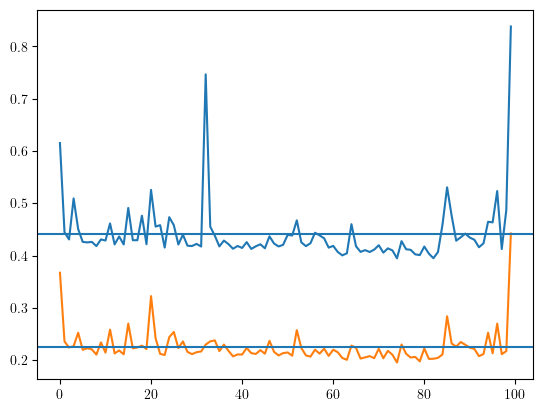

In [78]:
plt.plot(totrun)
plt.plot(backrun)
plt.axhline(sum(totrun)/100)
plt.axhline(sum(backrun)/100)

In [79]:
sum(backrun)/100

0.22585927009582518

In [80]:
sum(totrun)/100

0.441490626335144

In [26]:
final_abun=[fabun[-1] for fabun in solY]
final_abun

[8.277087507413366e-12,
 0.7529101890502133,
 1.9064595110602117e-05,
 6.168281469217527e-08,
 7.765675940060916e-06,
 0.06175704929839011,
 5.648112962612672e-15,
 2.2646438100419125e-11,
 2.2026667993184936e-27,
 3.3210140255726154e-10,
 4.011812311429834e-18,
 1.4008719947564634e-25,
 4.5749417562507684e-21,
 2.9819932111429075e-16,
 2.342435674181526e-34,
 1.51474236412196e-32,
 5.268800698099842e-16,
 9.937967830873975e-17,
 9.81099516260595e-18,
 3.0243915288861964e-53,
 1.150303442103514e-30,
 3.9536879308404755e-17,
 1.2811445770819679e-20,
 1.1627012407149636e-47,
 1.690705450042446e-34,
 4.427263976500694e-20]

In [27]:
[8.277142164402353e-12,
 0.7529025101033204,
 1.9065859914436615e-05,
 6.16872284511038e-08,
 7.765804723247095e-06,
 0.06175896830284235,
 5.648718325006063e-15,
 2.2648451007701182e-11,
 2.202744862837942e-27,
 3.320756512763776e-10,
 4.0125064367293694e-18,
 1.4004157869816938e-25,
 4.575835604386078e-21,
 2.9820715186292637e-16,
 2.3422595440245336e-34,
 1.5146574903661696e-32,
 5.269279222369986e-16,
 9.93852258627775e-17,
 9.811573345354156e-18,
 3.0232778842308104e-53,
 1.1500454892754004e-30,
 3.9537342276116735e-17,
 1.281231900840681e-20,
 1.1620417058542524e-47,
 1.690149681289231e-34,
 4.425922154800807e-20]

[8.277142164402353e-12,
 0.7529025101033204,
 1.9065859914436615e-05,
 6.16872284511038e-08,
 7.765804723247095e-06,
 0.06175896830284235,
 5.648718325006063e-15,
 2.2648451007701182e-11,
 2.202744862837942e-27,
 3.320756512763776e-10,
 4.0125064367293694e-18,
 1.4004157869816938e-25,
 4.575835604386078e-21,
 2.9820715186292637e-16,
 2.3422595440245336e-34,
 1.5146574903661696e-32,
 5.269279222369986e-16,
 9.93852258627775e-17,
 9.811573345354156e-18,
 3.0232778842308104e-53,
 1.1500454892754004e-30,
 3.9537342276116735e-17,
 1.281231900840681e-20,
 1.1620417058542524e-47,
 1.690149681289231e-34,
 4.425922154800807e-20]

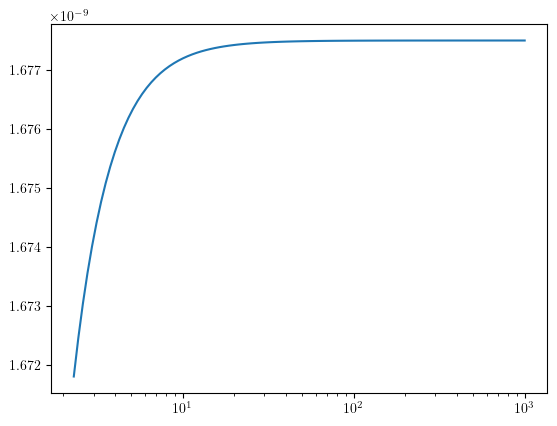

In [28]:
plt.plot(T_inis,[eta*(1+(rho_e(T_ini)+P_e(T_ini))/(rho_gamma(T_ini)+P_gamma(T_ini))) for T_ini in T_inis])
plt.xscale('log')

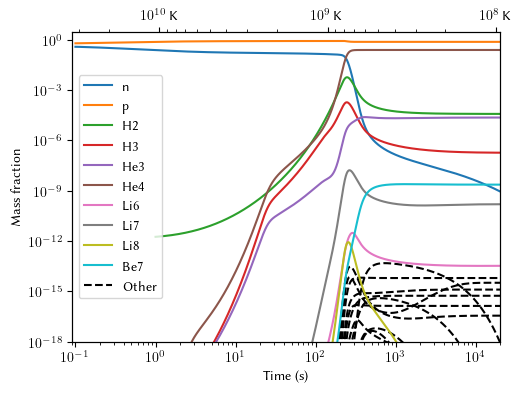

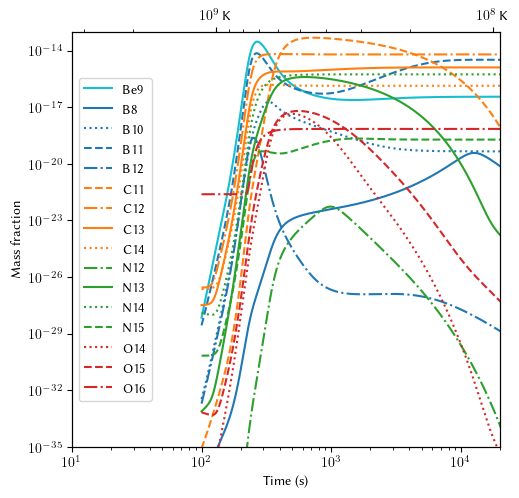

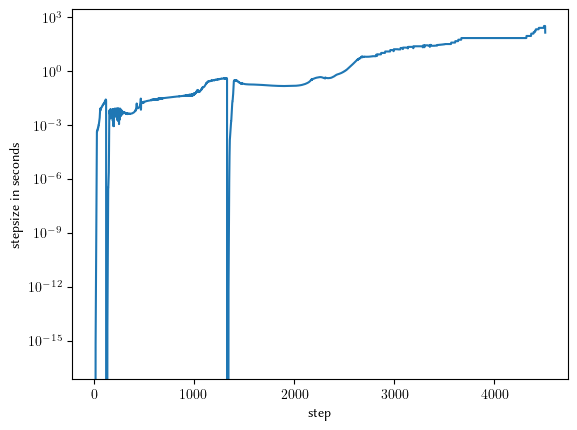

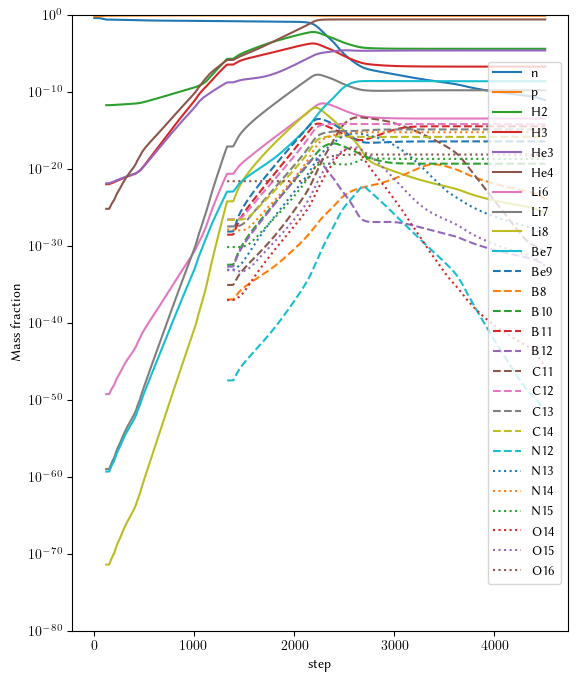

In [7]:
# Plot the results    
#soltime=midsoltimes[50]
#solY=midsolYs[50]


#plt.figure('abundance',figsize=(6.4, 8))
fig, axes = plt.subplots(1, 1, figsize=(width, 4))

fig.subplots_adjust(wspace=0.2, hspace=0.05, left=0.135, right=0.975, bottom=0.125, top=0.9)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
colors*=8
line=['-']*10+['--']*10+[':']*10+['-.']*10+['-']*10+['--']*10+[':']*10+['-.']*10


for i in range(10,fnNucs):
    plt.plot(soltime/timeunit, A[i]*solY[i],'k--')
for i in range(10):
    plt.plot(soltime/timeunit, A[i]*solY[i],line[i], color=colors[i], label=Y_labels[i])
plt.plot(soltime/timeunit, A[19]*solY[19],'k--', label='Other')

#solY[0:1]
#for i in range(10):
#    plt.plot(soltime/timeunit, np.array([get_Y_jac(np.array([T_cache(soltime[i]),a_cache(soltime[i])]+[solY[0][i],solY[1][i]]),1) for i in range(len(soltime))])
#,'--', color=colors[i], label=Y_labels[i])


#A[i]*get_Y_jac(y,i)[i]

#plt.axvline(soltime[1150]/timeunit)
plt.xlabel('Time (s)')
plt.ylabel('Mass fraction')
xlims=(0.09,2e4)
plt.ylim(1e-18,3)
plt.xlim(*xlims)
plt.xscale('log')
plt.yscale('log')

plt.legend(loc='center left')
plt.twiny()
plt.xscale('log')
plt.xlim(*(T_cache(timeunit*t)*TMeV2T9*1e9  for t in xlims))
plt.gca().xaxis.set_major_formatter(AddK())
#fig.savefig('TeX/figures/abundancelight.pdf')
plt.show()

####

fig, axes = plt.subplots(1, 1, figsize=(width, 5))

fig.subplots_adjust(wspace=0.2, hspace=0.05, left=0.135, right=0.975, bottom=0.1, top=0.93)

lateline=['-.','-',':','--']

#for i in range(10,fnNucs):
#    plt.plot(soltime/timeunit, A[i]*solY[i],lateline[(Z[i]-A[i])% 4], color=colors[A[i]-8], label=Y_labels[i])

for i in range(10,fnNucs):
    plt.plot(soltime/timeunit, A[i]*solY[i],'-' if i==11 else lateline[A[i]% 4], color=colors[(i-11)//4], label=Y_labels[i])



#plt.plot(soltime/timeunit, A[10]*solY[10],'k:', label='Be9')
#for i in range(11,fnNucs):
#    plt.plot(soltime/timeunit, A[i]*solY[i],lateline[i], color=colors[i% 4], label=Y_labels[i])

  
#plt.axvline(soltime[1200]/timeunit)
plt.xlabel('Time (s)')
plt.ylabel('Mass fraction')
plt.ylim(1e-35,1e-13)
xlims=(10,2e4)
plt.xlim(*xlims)
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='center left')
plt.twiny()
plt.xscale('log')
plt.xlim(*(T_cache(timeunit*t)*TMeV2T9*1e9 for t in xlims))
plt.gca().xaxis.set_major_formatter(AddK())

#fig.savefig('TeX/figures/abundanceheavy.pdf')
plt.show()

######

plt.figure('step size')
plt.plot(range(len(soltime)),[(soltime[i]-soltime[i-1])/timeunit for i in range(len(soltime))] )

plt.yscale('log')
plt.xlabel('step')
plt.ylabel('stepsize in seconds')
plt.show()

plt.figure('abundance',figsize=(6.4, 8))

for i in range(fnNucs):
      plt.plot(range(len(soltime)), A[i]*solY[i],line[i], color=colors[i], label=Y_labels[i])

plt.xlabel('step')
plt.ylabel('Mass fraction')
plt.ylim(1e-80,1)
#plt.xlim(0,20)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='right')
plt.show()

In [30]:
class AddMeV(plticks.LogFormatterSciNotation):
    def __call__(self, x, pos=None):
        x = plticks.LogFormatterSciNotation.__call__(self, x,pos)
        s = x+' MeV'
        return s

In [33]:
#test=rtolabuns[stabilitystep]

In [36]:
np.array(test)/rtolabuns[stabilitystep]-1

array([ 4.50381510e-10,  2.43627341e-12,  3.16006998e-10,  3.27968763e-10,
        1.16366250e-10, -7.50066675e-12,  3.04391845e-10,  2.07470041e-10,
        4.62168304e-10, -4.58290739e-10,  5.48378232e-10, -6.51537713e-10,
        5.86019011e-10, -6.65503652e-10, -4.10805501e-10,  3.88741928e-10,
       -7.55048246e-11, -2.58839061e-10, -4.62581862e-10,  1.95494954e-10,
       -2.68749800e-10, -5.05351427e-10, -4.89018270e-10, -4.62001437e-10,
       -6.98600289e-10, -6.40817732e-10])

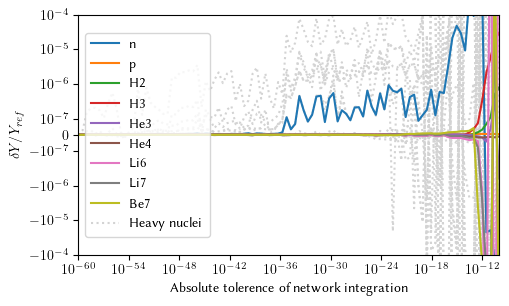

In [61]:

T_test=np.logspace(-2,1) 

#plt.plot(T_test,[rho_e(T) for T in T_test])
#plt.plot(T_test,[7/4*rho_gamma(T) for T in T_test])
#fig, axes = plt.subplots(1, 1, figsize=(width, height))
fig, axes = plt.subplots(1, 1, figsize=(width, 3))
stabilitystep=-1
fig.subplots_adjust(wspace=0.2, hspace=0.05, left=0.14, right=0.965, bottom=0.15, top=0.95)

for i in range(8,fnNucs):
    plt.plot(Tolerences,[(abun[i]-rtolabuns[stabilitystep][i])/rtolabuns[stabilitystep][i] for abun in rtolabuns],':',color='lightgray')

for i in [0,1,2,3,4,5,6,7,9]:#,11,12,13,15,16]:
    plt.plot(Tolerences,[(abun[i]-rtolabuns[stabilitystep][i])/rtolabuns[stabilitystep][i] for abun in rtolabuns],line[i],label=Y_labels[i])
#plt.plot(resolutionr,[(abun[11]-interabuns[stabilitystep][11])/interabuns[stabilitystep][11] for abun in interabuns],line[11],label=Y_labels[11])

plt.plot(Tolerences,[(abun[1]) for abun in rtolabuns],':',color='lightgray', label='Heavy nuclei')

#plt.plot(T_cache(soltime),np.array([rho_nu(a_cache(t))/rho_gamma(T_cache(t)) for t in soltime]))
#plt.xscale('log')
#plt.axhline(7/4,color='k',linestyle='--',label='7/4')
#plt.axhline(n_nu*7/8,color='k',linestyle='--',label='21/8')
plt.xlim(1e-60,1e-10)
#plt.xticks([1]+list(range(5,31,5)))
#plt.axvline(T_ini)
plt.yscale('symlog',linthresh=1.2e-7,linscale=0.5)
plt.xscale('log')
#plt.formatter.use_mathtext=True
#plt.ylim(1e-10,1)#
plt.ylabel(r'$\delta Y/Y_{ref}$')

plt.ylim(-1e-4,1e-4)
plt.xlabel('Absolute tolerence of network integration')
plt.legend(loc='center left')#title='Temperature')#(loc='right')
#50keV
#fig.savefig('TeX/figures/atolnet.pdf')

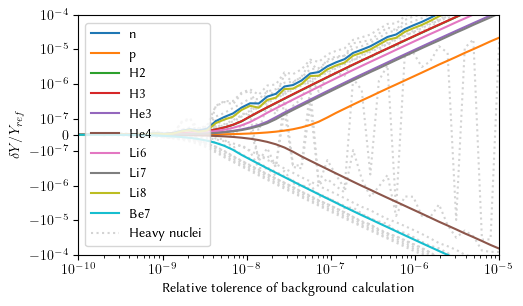

In [32]:

T_test=np.logspace(-2,1) 

#plt.plot(T_test,[rho_e(T) for T in T_test])
#plt.plot(T_test,[7/4*rho_gamma(T) for T in T_test])
#fig, axes = plt.subplots(1, 1, figsize=(width, height))
fig, axes = plt.subplots(1, 1, figsize=(width, 3))
stabilitystep=-1
fig.subplots_adjust(wspace=0.2, hspace=0.05, left=0.14, right=0.965, bottom=0.15, top=0.95)

for i in range(10,fnNucs):
    plt.plot(Tolerences,[(abun[i]-rtolabuns[stabilitystep][i])/rtolabuns[stabilitystep][i] for abun in rtolabuns],':',color='lightgray')

for i in range(10):#,11,12,13,15,16]:
    plt.plot(Tolerences,[(abun[i]-rtolabuns[stabilitystep][i])/rtolabuns[stabilitystep][i] for abun in rtolabuns],line[i],label=Y_labels[i])
#plt.plot(resolutionr,[(abun[11]-interabuns[stabilitystep][11])/interabuns[stabilitystep][11] for abun in interabuns],line[11],label=Y_labels[11])

plt.plot(Tolerences,[(abun[1]) for abun in rtolabuns],':',color='lightgray', label='Heavy nuclei')

#plt.plot(T_cache(soltime),np.array([rho_nu(a_cache(t))/rho_gamma(T_cache(t)) for t in soltime]))
#plt.xscale('log')
#plt.axhline(7/4,color='k',linestyle='--',label='7/4')
#plt.axhline(n_nu*7/8,color='k',linestyle='--',label='21/8')
plt.xlim(1e-10,1e-5)
#plt.xticks([1]+list(range(5,31,5)))
#plt.axvline(T_ini)
plt.yscale('symlog',linthresh=1.2e-7,linscale=0.5)
plt.xscale('log')
#plt.formatter.use_mathtext=True
#plt.ylim(1e-10,1)#
plt.ylabel(r'$\delta Y/Y_{ref}$')

plt.ylim(-1e-4,1e-4)
plt.xlabel('Relative tolerence of background calculation')
plt.legend(loc='center left')#title='Temperature')#(loc='right')
#50keV
#fig.savefig('TeX/figures/rtolbackground.pdf')

In [31]:
#nodecoupabuns=T_iniabuns
#nodecoupTs=T_inis

In [32]:
T_inis

array([   2.3       ,    2.44555283,    2.60031681,    2.76487485,
          2.93984675,    3.12589154,    3.32370996,    3.53404709,
          3.75769517,    3.99549655,    4.24834692,    4.51719863,
          4.80306431,    5.10702066,    5.43021255,    5.77385725,
          6.13924912,    6.52776438,    6.94086638,    7.38011107,
          7.84715284,    8.34375081,    8.87177541,    9.43321543,
         10.03018554,   10.6649342 ,   11.3398522 ,   12.0574816 ,
         12.82052535,   13.63185744,   14.49453373,   15.4118035 ,
         16.38712162,   17.42416162,   18.52682949,   19.69927841,
         20.94592441,   22.27146296,   23.68088668,   25.17950414,
         26.77295988,   28.46725561,   30.26877288,   32.18429709,
         34.22104302,   36.38668206,   38.68937106,   41.13778306,
         43.74113997,   46.50924731,   49.45253112,   52.58207723,
         55.90967303,   59.44785188,   63.20994028,   67.21010808,
         71.46342186,   75.98590168,   80.79458139,   85.90757

(-0.001, 0.001)

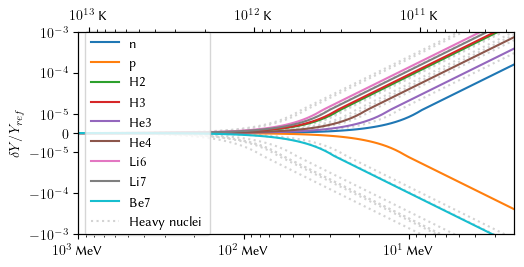

In [33]:



#plt.plot(T_test,[rho_e(T) for T in T_test])
#plt.plot(T_test,[7/4*rho_gamma(T) for T in T_test])
#fig, axes = plt.subplots(1, 1, figsize=(width, height))
fig, axes = plt.subplots(1, 1, figsize=(width, 2.5))
stabilitystep=-1
fig.subplots_adjust(wspace=0.2, hspace=0.05, left=0.14, right=0.995, bottom=0.08, top=0.890)

for i in range(10,fnNucs):
    plt.plot(T_inis,[(abun[i]-T_iniabuns[stabilitystep][i])/T_iniabuns[stabilitystep][i] for abun in T_iniabuns],':',color='lightgray')
plt.plot(T_inis,[(abun[8]-T_iniabuns[stabilitystep][8])/T_iniabuns[stabilitystep][8] for abun in T_iniabuns],':',color='lightgray')

for i in [0,1,2,3,4,5,6,7,9]:#,11,12,13,15,16]:
    plt.plot(T_inis,[(abun[i]-T_iniabuns[stabilitystep][i])/T_iniabuns[stabilitystep][i] for abun in T_iniabuns],line[i],color=colors[i],label=Y_labels[i])
#plt.plot(resolutionr,[(abun[11]-interabuns[stabilitystep][11])/interabuns[stabilitystep][11] for abun in interabuns],line[11],label=Y_labels[11])

plt.plot(T_inis,[(abun[1]) for abun in T_iniabuns],':',color='lightgray', label='Heavy nuclei')

#plt.plot(T_cache(soltime),np.array([rho_nu(a_cache(t))/rho_gamma(T_cache(t)) for t in soltime]))
#plt.xscale('log')
#plt.axhline(7/4,color='k',linestyle='--',label='7/4')
#plt.axhline(n_nu*7/8,color='k',linestyle='--',label='21/8')
#plt.xlim(1,30)
#plt.xticks([1]+list(range(5,31,5)))
#plt.axvline(T_ini)
plt.yscale('symlog',linthresh=1.2e-5,linscale=0.5)
plt.xscale('log')
xlims=(1000,2.3)
plt.xlim(*xlims)
plt.gca().xaxis.set_major_formatter(AddMeV())
#plt.formatter.use_mathtext=True
#plt.ylim(1e-10,1)#
plt.ylabel(r'$\delta Y/Y_{ref}$')
plt.legend(loc='center left')#title='Temperature')#(loc='right')

plt.twiny()
plt.xscale('log')
plt.xlim(*(T*TMeV2T9*1e9  for T in xlims))
plt.gca().xaxis.set_major_formatter(AddK())

plt.ylim(-1e-3,1e-3)
#plt.ylabel(r'$\rho_{e}/\rho_{\gamma}$')

#50keV
#fig.savefig('TeX/figures/initime.pdf')

(-0.001, 0.001)

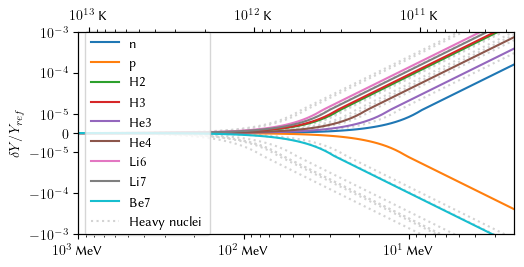

In [36]:



#plt.plot(T_test,[rho_e(T) for T in T_test])
#plt.plot(T_test,[7/4*rho_gamma(T) for T in T_test])
#fig, axes = plt.subplots(1, 1, figsize=(width, height))
fig, axes = plt.subplots(1, 1, figsize=(width, 2.5))
stabilitystep=-1
fig.subplots_adjust(wspace=0.2, hspace=0.05, left=0.14, right=0.995, bottom=0.08, top=0.890)

for i in range(10,fnNucs):
    plt.plot(T_inis,[(abun[i]-T_iniabuns[stabilitystep][i])/T_iniabuns[stabilitystep][i] for abun in T_iniabuns],':',color='lightgray')
plt.plot(T_inis,[(abun[8]-T_iniabuns[stabilitystep][8])/T_iniabuns[stabilitystep][8] for abun in T_iniabuns],':',color='lightgray')

for i in [0,1,2,3,4,5,6,7,9]:#,11,12,13,15,16]:
    plt.plot(T_inis,[(abun[i]-T_iniabuns[stabilitystep][i])/T_iniabuns[stabilitystep][i] for abun in T_iniabuns],line[i],color=colors[i],label=Y_labels[i])
#plt.plot(resolutionr,[(abun[11]-interabuns[stabilitystep][11])/interabuns[stabilitystep][11] for abun in interabuns],line[11],label=Y_labels[11])

plt.plot(T_inis,[(abun[1]) for abun in T_iniabuns],':',color='lightgray', label='Heavy nuclei')

#plt.plot(T_cache(soltime),np.array([rho_nu(a_cache(t))/rho_gamma(T_cache(t)) for t in soltime]))
#plt.xscale('log')
#plt.axhline(7/4,color='k',linestyle='--',label='7/4')
#plt.axhline(n_nu*7/8,color='k',linestyle='--',label='21/8')
#plt.xlim(1,30)
#plt.xticks([1]+list(range(5,31,5)))
#plt.axvline(T_ini)
plt.yscale('symlog',linthresh=1.2e-5,linscale=0.5)
plt.xscale('log')
xlims=(1000,2.3)
plt.xlim(*xlims)
plt.gca().xaxis.set_major_formatter(AddMeV())
#plt.formatter.use_mathtext=True
#plt.ylim(1e-10,1)#
plt.ylabel(r'$\delta Y/Y_{ref}$')
plt.legend(loc='center left')#title='Temperature')#(loc='right')

plt.twiny()
plt.xscale('log')
plt.xlim(*(T*TMeV2T9*1e9  for T in xlims))
plt.gca().xaxis.set_major_formatter(AddK())

plt.ylim(-1e-3,1e-3)
#plt.ylabel(r'$\rho_{e}/\rho_{\gamma}$')

#50keV
#fig.savefig('TeX/figures/initime.pdf')

NameError: name 'interEvals' is not defined

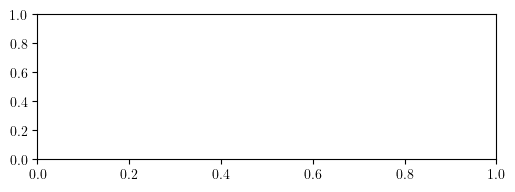

In [35]:
fig, axes = plt.subplots(1, 1, figsize=(width, 2))
stabilitystep=-1
fig.subplots_adjust(wspace=0.2, hspace=0.05, left=0.075, right=0.975, bottom=0.225, top=0.95)

plt.plot(resolutionr,interEvals)
plt.xscale('log')

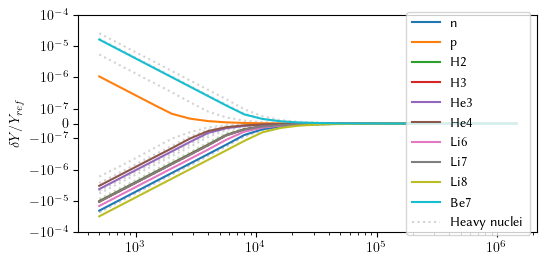

: 

In [ ]:

T_test=np.logspace(-2,1) 

#plt.plot(T_test,[rho_e(T) for T in T_test])
#plt.plot(T_test,[7/4*rho_gamma(T) for T in T_test])
#fig, axes = plt.subplots(1, 1, figsize=(width, height))
fig, axes = plt.subplots(1, 1, figsize=(width, 3))
stabilitystep=-1
fig.subplots_adjust(wspace=0.2, hspace=0.05, left=0.075, right=0.975, bottom=0.225, top=0.95)

for i in range(10,fnNucs):
    plt.plot(resolutionr,[(abun[i]-interabuns[stabilitystep][i])/interabuns[stabilitystep][i] for abun in interabuns],':',color='lightgray')

for i in range(10):#,11,12,13,15,16]:
    plt.plot(resolutionr,[(abun[i]-interabuns[stabilitystep][i])/interabuns[stabilitystep][i] for abun in interabuns],line[i],label=Y_labels[i])
#plt.plot(resolutionr,[(abun[11]-interabuns[stabilitystep][11])/interabuns[stabilitystep][11] for abun in interabuns],line[11],label=Y_labels[11])

plt.plot(resolutionr,[(abun[1]) for abun in interabuns],':',color='lightgray', label='Heavy nuclei')

#plt.plot(T_cache(soltime),np.array([rho_nu(a_cache(t))/rho_gamma(T_cache(t)) for t in soltime]))
#plt.xscale('log')
#plt.axhline(7/4,color='k',linestyle='--',label='7/4')
#plt.axhline(n_nu*7/8,color='k',linestyle='--',label='21/8')
#plt.xlim(1,30)
#plt.xticks([1]+list(range(5,31,5)))
#plt.axvline(T_ini)
plt.yscale('symlog',linthresh=1.2e-7,linscale=0.5)
plt.xscale('log')
#plt.formatter.use_mathtext=True
#plt.ylim(1e-10,1)#
plt.ylabel(r'$\delta Y/Y_{ref}$')

plt.ylim(-1e-4,1e-4)
#plt.ylabel(r'$\rho_{e}/\rho_{\gamma}$')
plt.legend(loc='right')#title='Temperature')#(loc='right')
#50keV
#fig.savefig('TeX/figures/interpol.pdf')

In [ ]:
# N_eff  xie  xix  tau  rholmbd  eta10  OmegaBh^2  phie  thetah  tnuh  nbh  N/H  Y_H  H2/H  H3/H  He3/H  Y_p  Li6/H  Li7/H  Be7/H  Li8/H  B8/H  Be9/H  B10/H  B11/H  C11/H  B12/H  C12/H  N12/H  C13/H  N13/H  C14/H  N14/H  O14/H  N15/H  O15/H  O16/H
 3.0000000e+00  0.0000000e+00  0.0000000e+00  8.8030000e+02  0.0000000e+00  6.1000000e+00  2.2280000e-02  3.9408900e+01  8.6855000e-26  7.1495800e-01  5.0648300e-16  9.3360000e-10  7.5430800e-01  2.5367300e-05  8.1552200e-08  1.0358600e-05  2.4699700e-01  1.1027000e-14  4.6285000e-10  4.3544100e-10  1.0700700e-24  7.3446300e-22  2.4140700e-19  3.3098700e-21  3.9619900e-16  2.9407800e-20  1.3281700e-30  4.4468800e-16  1.3281700e-30  9.4917800e-17  4.3943200e-26  1.2499500e-17  3.6487000e-17  1.3281700e-30  1.1456600e-20  2.3727600e-29  4.5946900e-20

In [ ]:
# N_eff  xie  xix  tau  rholmbd  eta10  OmegaBh^2  phie  thetah  tnuh  nbh  N/H  Y_H  H2/H  H3/H  He3/H  Y_p  Li6/H  Li7/H  Be7/H  Li8/H  B8/H  Be9/H  B10/H  B11/H  C11/H  B12/H  C12/H  N12/H  C13/H  N13/H  C14/H  N14/H  O14/H  N15/H  O15/H  O16/H
 3.0000000e+00  0.0000000e+00  0.0000000e+00  8.7940000e+02  0.0000000e+00  6.1383200e+00  2.2420000e-02  3.9415300e+01  8.6855000e-26  7.1495800e-01  5.0966200e-16  9.1691800e-10  7.5443300e-01  2.5096000e-05  8.0645400e-08  1.0319200e-05  2.4688100e-01  1.0902600e-14  4.6878200e-10  4.4161600e-10  1.0484000e-24  7.4970500e-22  2.3738000e-19  3.2421500e-21  4.0436900e-16  3.0144100e-20  1.3278900e-30  4.4472100e-16  1.3278900e-30  9.5434700e-17  4.4233500e-26  1.2627800e-17  3.6998500e-17  1.3278900e-30  1.1613700e-20  2.4738900e-29  4.6716800e-20

In [ ]:
# N_eff  xie  xix  tau  rholmbd  eta10  OmegaBh^2  phie  thetah  tnuh  nbh  N/H  Y_H  H2/H  H3/H  He3/H  Y_p  Li6/H  Li7/H  Be7/H  Li8/H  B8/H  Be9/H  B10/H  B11/H  C11/H  B12/H  C12/H  N12/H  C13/H  N13/H  C14/H  N14/H  O14/H  N15/H  O15/H  O16/H
 3.0400000e+00  0.0000000e+00  0.0000000e+00  8.8030000e+02  0.0000000e+00  6.1000000e+00  2.2280000e-02  3.9408700e+01  8.7077900e-26  7.1495800e-01  5.0648500e-16  9.4290600e-10  7.5380000e-01  2.5495000e-05  8.1989200e-08  1.0376500e-05  2.4752000e-01  1.1112200e-14  4.6127200e-10  4.3367600e-10  1.0874800e-24  7.3103900e-22  2.4398000e-19  3.3581700e-21  3.9721700e-16  3.0164700e-20  1.3290000e-30  4.4740900e-16  1.3290000e-30  9.5312700e-17  4.4255000e-26  1.2556300e-17  3.6527200e-17  1.3290000e-30  1.1511400e-20  2.4243800e-29  4.6092600e-20

In [ ]:
# N_eff  xie  xix  tau  rholmbd  eta10  OmegaBh^2  phie  thetah  tnuh  nbh  N/H  Y_H  H2/H  H3/H  He3/H  Y_p  Li6/H  Li7/H  Be7/H  Li8/H  B8/H  Be9/H  B10/H  B11/H  C11/H  B12/H  C12/H  N12/H  C13/H  N13/H  C14/H  N14/H  O14/H  N15/H  O15/H  O16/H